In [0]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
seaborn.set_palette('colorblind')

import os

import itertools
from plot import create_bw_image

In [0]:

# For saving the model
model_save_folder = '.'

In [0]:
#import pickle
#import gzip
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train=X_train.astype(np.float32) / 255
X_test=X_test.astype(np.float32) / 255
#train, val, test = pickle.load(gzip.open(mnist_folder), encoding='bytes')

#X_train, y_train = train
#X_val, y_val = val

X_train_topo = X_train.reshape(X_train.shape[0], 1, 28,28)
X_val_topo = X_test.reshape(X_test.shape[0], 1, 28,28)

from numpy.random import RandomState

In [0]:
mask = y_train < 10 # all, can use this to only take a subset of classes
x = X_train_topo[mask]#[:1000]
y = y_train[mask]

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

In [0]:
from util import set_random_seeds
from revnet import init_model_params
import torch as th
from models import create_MNIST_model
th.backends.cudnn.benchmark = True
set_random_seeds(34093049, True)
feature_model = create_MNIST_model()

feature_model = feature_model.cuda()
init_model_params(feature_model, 1)

n_dims = 1024#int(np.prod(x.shape[1:])) 
n_clusters = int(len(np.unique(y)))

# will be initialized properly later
means_per_cluster = [th.autograd.Variable(th.zeros(n_dims).cuda(), requires_grad=True)
                     for _ in range(n_clusters)]
stds_per_cluster = [th.autograd.Variable(th.ones(n_dims).cuda(), requires_grad=True)
                    for _ in range(n_clusters)]

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from training import hard_init_std_mean
from util import np_to_var

inputs = np_to_var(x, dtype=np.float32).cuda()
targets = np_to_var(np.array([y == i for i in range(len(np.unique(y)))]).T, dtype=np.float32).cuda()


hard_init_std_mean(means_per_cluster, stds_per_cluster, feature_model, inputs[:10000], targets[:10000], )

optimizer = th.optim.Adam([
    {'params': list(feature_model.parameters()) + 
     means_per_cluster + stds_per_cluster,
    'lr': 0.001},],)

In [0]:
from iterators import BalancedBatchSizeIterator

batch_size = 650
iterator = BalancedBatchSizeIterator(batch_size,)

In [0]:

from revnet import invert
from gaussian import get_gauss_samples
def reconstruct_loss(feature_model, inputs,outputs,):
    inputs = invert(feature_model, outputs)
    perturbation = get_gauss_samples(
        len(outputs), th.zeros_like(outputs[0]).detach(), th.ones_like(outputs[0].detach()) * 0.01)
    o_perturbed = outputs + perturbation
    inputs_perturbed = invert(feature_model, o_perturbed)
    diffs = inputs - inputs_perturbed
    loss = th.mean(diffs * diffs)
    loss += th.mean(th.abs(diffs))
    return loss

In [0]:

from util import ensure_on_same_device, np_to_var, var_to_np
def ot_euclidean_loss(outs, mean, std):
    
    gauss_samples = get_gauss_samples(len(outs), mean, std)

    diffs = outs.unsqueeze(1) - gauss_samples.unsqueeze(0)
    del gauss_samples
    diffs = th.sqrt(th.clamp(th.sum(diffs * diffs, dim=2), min=1e-6))
    #transport_mat = scipy.stats.wasserstein_distance
    #transport_mat = ot.emd([],[], var_to_np(diffs))
    # sometimes weird low values, try to prevent them
    #transport_mat = transport_mat * (transport_mat > (1.0/(diffs.numel())))

    #transport_mat = np_to_var(transport_mat, dtype=np.float32)
    #diffs, transport_mat = ensure_on_same_device(diffs, transport_mat)
    loss = th.sum(diffs)
    #loss = th.sum(transport_mat * diffs)
    return loss

In [0]:
import time
def train_one_epoch():
    start_time = time.time()
    b_gens = [iterator.get_batches(inputs[targets[:,i_cluster] == 1],
                                  targets[targets[:,i_cluster] == 1], shuffle=True)
                for i_cluster in range(len(means_per_cluster))]

    more_batches = True
    rec_losses = []
    ot_losses = []
    losses = []
    while more_batches:
        optimizer.zero_grad()
        for i_cluster in range(len(b_gens)):
            b_gen = b_gens[i_cluster]
            try:
                b_X, b_y = next(b_gen)
                outs = feature_model(b_X)
                rec_loss = reconstruct_loss(feature_model, b_X, outs,)
                ot_loss = ot_euclidean_loss(outs, means_per_cluster[i_cluster], stds_per_cluster[i_cluster])
                loss = rec_loss * 15 + ot_loss
                loss.backward()
                rec_losses.append(var_to_np(rec_loss))
                ot_losses.append(var_to_np(ot_loss))
                losses.append(var_to_np(loss))
            except StopIteration:
                more_batches = False
        optimizer.step()
        for i_cluster in range(len(stds_per_cluster)):
            stds_per_cluster[i_cluster].data.clamp_(min=0)
            runtime = time.time() - start_time
    return {'rec_loss': np.mean(rec_losses),
           'ot_losses': np.mean(ot_losses),
           'loss': np.mean(losses),
           'runtime': runtime}

In [0]:
import pandas as pd
epochs_dataframe = pd.DataFrame()

In [0]:
def test_reconstruction_and_interpolation():
    feature_model.eval()
    original = create_bw_image(X_test[20:40].reshape(1,20,28,28))
    print("original")
    display(original)

    t_X = X_test#, t_y = test

    #numpy needs to be shaped (number_of_samples, 1, sample_x_size, sample_y_size)
    torch_X = torch.from_numpy(t_X[20:40].reshape((20,1,28,28))).cuda()
    outs = feature_model(torch_X)

    torch_X_2 = torch.from_numpy(t_X[40:60].reshape((20,1,28,28))).cuda()
    outs_2 = feature_model(torch_X_2)

    print("interpolation from reconstructed test samples")
    interp=np.empty((8,20,1,28,28))
    for j in range(0,8):
        interp[j]=var_to_np(invert(feature_model, (outs_2*j+outs*(7-j))/7))
    ireconstruction = np.copy(interp.reshape(8,20,28,28))
    im2 = create_bw_image(ireconstruction)
    display(im2)



In [0]:

from util import var_to_np
from datetime import datetime
def mainloop():
 rng = RandomState(1)
 for i_epoch in range(100001):
    feature_model.train()
    result = train_one_epoch()
    feature_model.eval()
    #epochs_dataframe = epochs_dataframe.append(result, ignore_index=True)
    if i_epoch % 10 == 0:
      test_reconstruction_and_interpolation()
        
        

    if i_epoch % 30 == 0:
        ti= datetime.now().strftime("%Y:%m:%d_%H:%M:%S")
        #folder =  os.path.join(model_save_folder, str(len(epochs_dataframe)))
        #os.makedirs(folder, exist_ok=False)
        epochs_dataframe.to_csv(ti+'epochs_df.csv')
        th.save(optimizer.state_dict(), ti+'optim_dict.pkl')
        th.save(feature_model.state_dict(), ti+'model_dict.pkl')
        th.save(means_per_cluster, ti+ 'means.pkl')
        th.save(stds_per_cluster, ti+ 'stds.pkl')
        log.info("Saved")

original


interpolation from reconstructed test samples


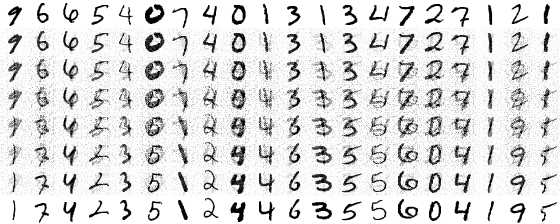

In [104]:
test_reconstruction_and_interpolation()




original


interpolation from reconstructed test samples


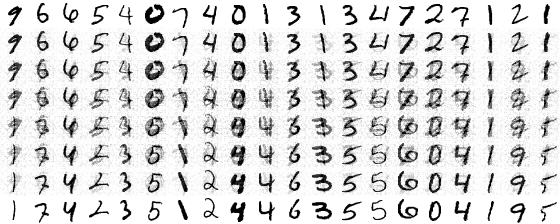

2020-01-28 20:12:10,869 INFO : Saved
original


interpolation from reconstructed test samples


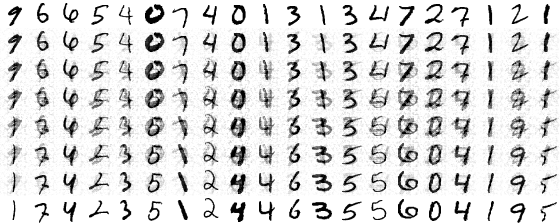

original


interpolation from reconstructed test samples


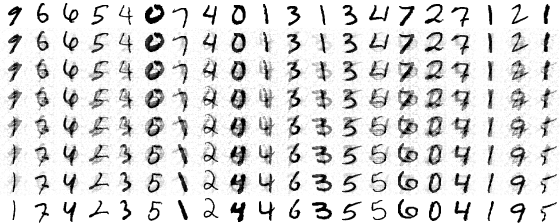

original


interpolation from reconstructed test samples


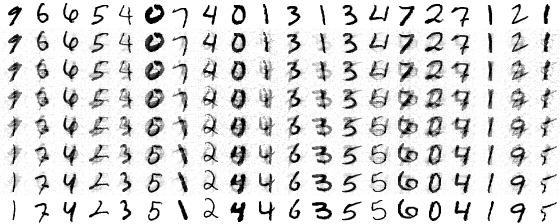

2020-01-28 20:25:26,507 INFO : Saved
original


interpolation from reconstructed test samples


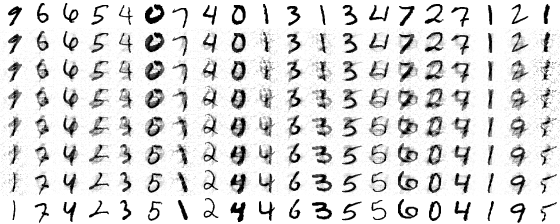

original


interpolation from reconstructed test samples


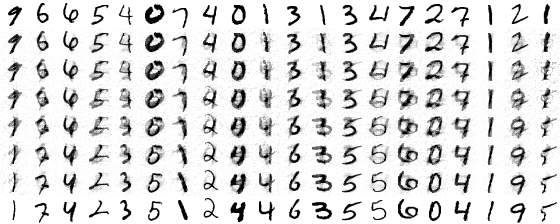

original


interpolation from reconstructed test samples


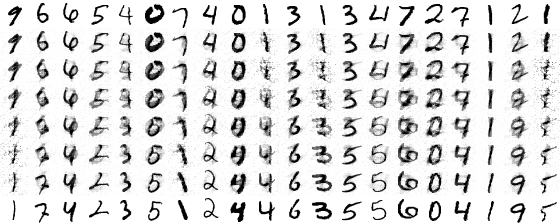

2020-01-28 20:38:42,657 INFO : Saved
original


interpolation from reconstructed test samples


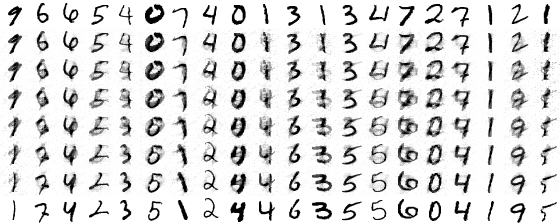

original


interpolation from reconstructed test samples


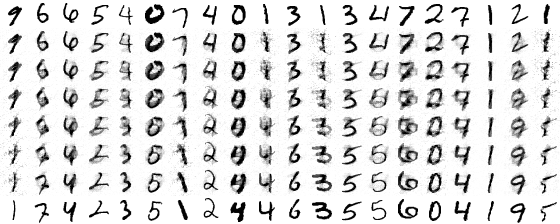

original


interpolation from reconstructed test samples


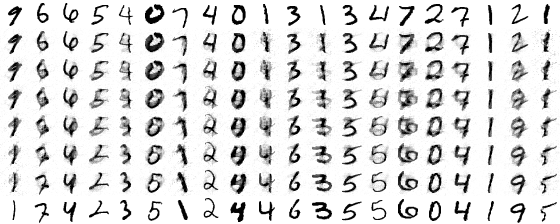

2020-01-28 20:51:59,176 INFO : Saved
original


interpolation from reconstructed test samples


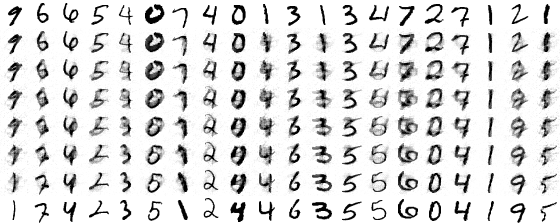

original


interpolation from reconstructed test samples


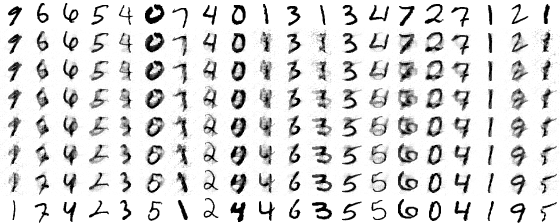

original


interpolation from reconstructed test samples


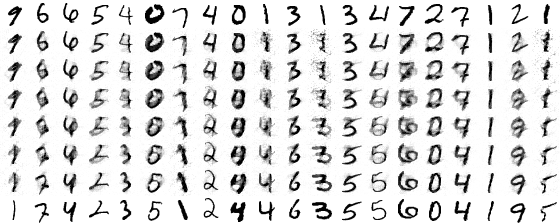

2020-01-28 21:05:15,803 INFO : Saved
original


interpolation from reconstructed test samples


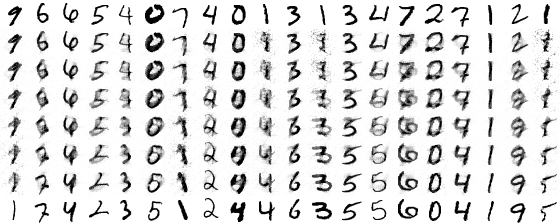

original


interpolation from reconstructed test samples


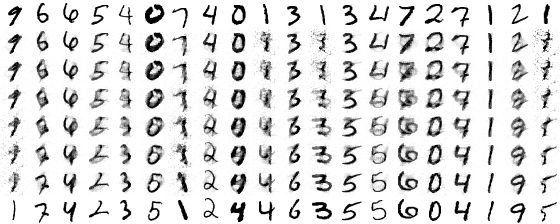

original


interpolation from reconstructed test samples


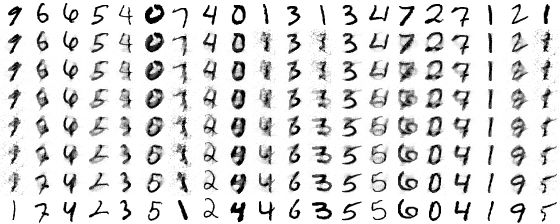

2020-01-28 21:18:32,756 INFO : Saved
original


interpolation from reconstructed test samples


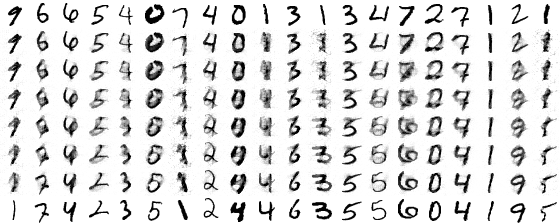

original


interpolation from reconstructed test samples


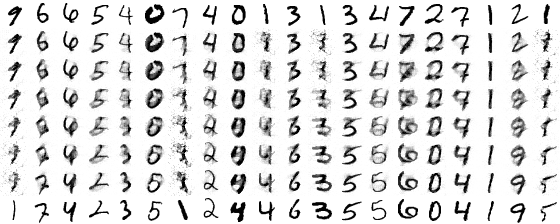

original


interpolation from reconstructed test samples


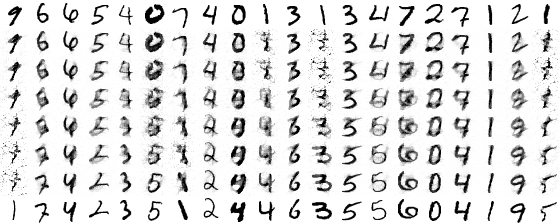

2020-01-28 21:31:49,548 INFO : Saved
original


interpolation from reconstructed test samples


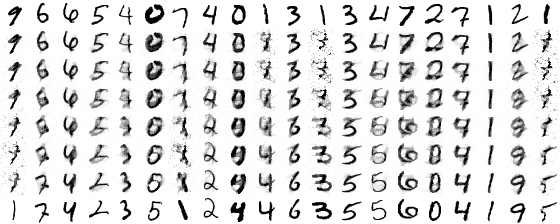

original


interpolation from reconstructed test samples


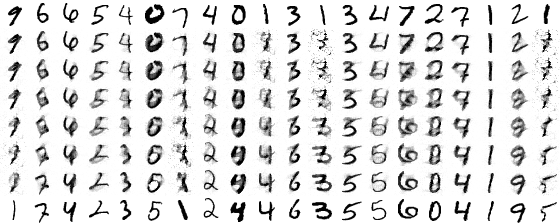

original


interpolation from reconstructed test samples


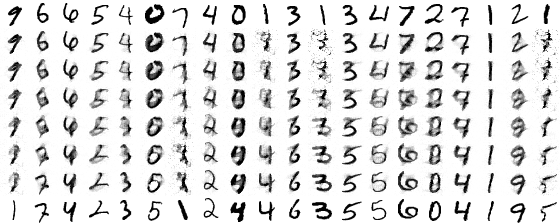

2020-01-28 21:45:06,657 INFO : Saved
original


interpolation from reconstructed test samples


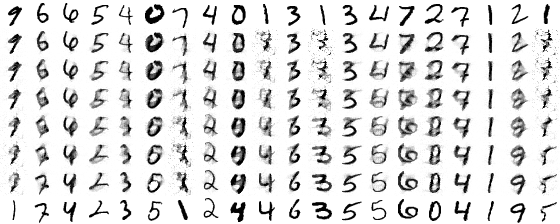

original


interpolation from reconstructed test samples


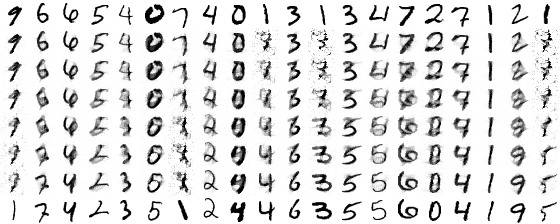

original


interpolation from reconstructed test samples


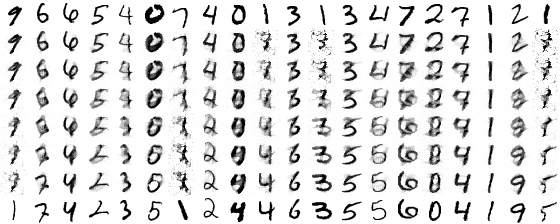

2020-01-28 21:58:24,046 INFO : Saved
original


interpolation from reconstructed test samples


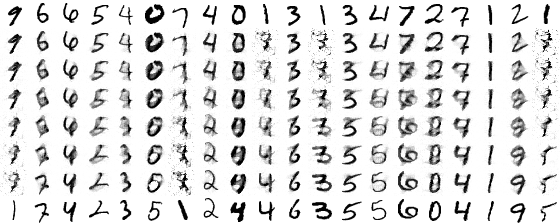

original


interpolation from reconstructed test samples


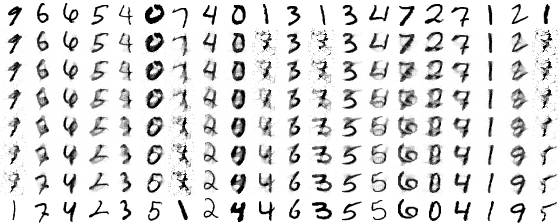

original


interpolation from reconstructed test samples


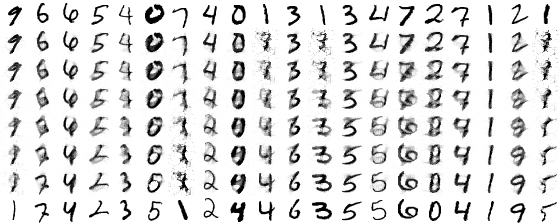

2020-01-28 22:11:41,185 INFO : Saved


KeyboardInterrupt: ignored

In [109]:
mainloop()
